In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
    except RuntimeError as e:
        print(e)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
from time import time
import json
from glob import glob
from PIL import Image
import pickle
from functools import lru_cache
import os

# the compute_blue implementation is taken from:
# https://github.com/tensorflow/models/blob/master/official/nlp/transformer/compute_bleu.py
from helpers.evaluation import compute_bleu
from helpers.files import load_config

In [3]:
config = load_config('config.json')

# Download Data

In [4]:
# Download caption annotation files
dataset_config = config['dataset']
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('./datasets') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('./datasets'),
                                          origin = dataset_config['annotation_url'],
                                          extract = True)
    os.remove(annotation_zip)
    annotation_file = os.path.dirname(annotation_folder) + '/annotations/captions_train2014.json'
else:
    annotation_file = './datasets/annotations/captions_train2014.json'

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('./datasets') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('./datasets'),
                                      origin = dataset_config['images_url'],
                                      extract = True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('./datasets') + image_folder

# Load Dataset

In [5]:
with open(annotation_file, 'r') as f:
        annotations = json.load(f)

def load_dataset(annotations, shuffle=True, 
                 test_size=0.2, num_examples=None):

    # variables to store the images url and their corresponding captions.
    all_captions = []
    all_img_id_vector = []

    # for each annotation add sos and eos tokens and map 
    for annotation in annotations['annotations']:
        caption = '<sos> ' + annotation['caption'] + ' <eos>'
        image_id = annotation['image_id']
        all_img_id_vector.append(image_id)
        all_captions.append(caption)
    
    train_imgs, test_imgs, train_captions, test_captions = train_test_split(all_img_id_vector[:num_examples],
                                                                            all_captions[:num_examples], 
                                                                            test_size=test_size, shuffle=shuffle)
    
    return train_imgs, test_imgs, train_captions, test_captions

In [6]:
num_examples = dataset_config['num_examples']
X_train, X_test, y_train, y_test = load_dataset(annotations, num_examples=num_examples)

In [7]:
@lru_cache(maxsize=256)
def get_all_captions_by_image_id(image_id):
    captions = []
    for caption in annotations['annotations']:
        if caption['image_id'] == image_id:
            captions.append(caption['caption'])
    return captions

def get_all_captions_by_image_ids(image_ids):
    return [get_all_captions_by_image_id(img_id) for img_id in image_ids]

In [8]:
captions = get_all_captions_by_image_id(X_train[0])
captions

['A compact car with bicycles mounted on the roof. ',
 'A car with a bunch of bicycles strapped to its roof.',
 'A car with several bikes on a bike rack. ',
 "A car is loaded down with many bicycles attached to it's roof.",
 "A car has multiple bikes hooked onto it's roof."]

# Preprocessing

## Encoder Preprocessing

We are going to use inceptionV3 model and hence its processing

1. We will load the image from the ID.
2. Resize the image to 299x299
3. Preprocess using InceptionV3 preprocess function

In [9]:
def preprocess_image(image_id):
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

def preprocess_images(image_ids):
    processed_images = np.zeros((len(image_ids), 299, 299, 3), dtype=np.float32)
    for i, img_id in enumerate(image_ids):
        processed_images[i], _ = preprocess_image(img_id)
    return processed_images

## Decoder Preprocessing

As usual, we need to:

1. Split, clean and tokenize the texts to build the vocabulary.
2. Constrain number of words to most common words and add the rest of words to Out-of-Vocabulary bucket.
3. Convert the texts to sequences.
4. Pad the texts to maximum

In [10]:
top_k = dataset_config['top_common_words']
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<UNK>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~\'')
tokenizer.fit_on_texts(y_train)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

y_train = tokenizer.texts_to_sequences(y_train)
y_test = tokenizer.texts_to_sequences(y_test)

y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding="post")
max_length = y_train.shape[-1]

y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test, padding="post", maxlen=max_length)

# Create Dataset

In [11]:
def preprocess(enc_input, dec_input,):
    enc_input, _ = preprocess_image(enc_input)
    return enc_input, dec_input

def set_shapes(img, cap, img_shape, cap_shape):
    img.set_shape(img_shape)
    cap.set_shape(cap_shape)
    return img, cap

def create_shifted_target(y):
    "remove the start token and append a padding to the end."
    return y[:, :-1], y[:, 1:]

In [12]:
batch_size = dataset_config['batch_size']
buffer_size = 1000
dec_input, train_target = create_shifted_target(y_train)
attention_weights = np.zeros((len(dec_input)), dtype=np.float32)

dataset_input = tf.data.Dataset.from_tensor_slices((X_train, dec_input))
dataset_target = tf.data.Dataset.from_tensor_slices((train_target, attention_weights))


# Use map to load the numpy files in parallel
dataset_input = dataset_input.map(lambda item1, item2: tf.py_function(
                preprocess, [item1, item2], (tf.float32, tf.int32)),
                num_parallel_calls=tf.data.experimental.AUTOTUNE)

img_shape = (299, 299, 3)
cap_shape = (max_length-1,)

# when the preprocessing is done in py_function or numpy_function, the shapes are lost!
# so we have to set the shape again for the input.
dataset_input = dataset_input.map(lambda item1, item2: set_shapes(item1, item2, img_shape, cap_shape))

# Shuffle and batch
dataset = tf.data.Dataset.zip((dataset_input, dataset_target))
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True).repeat().prefetch(tf.data.experimental.AUTOTUNE)

# Build Model

In [13]:
model_config = config['model']
epochs = model_config['epochs']
embedding_dim = model_config['embedding_dim']
units = model_config['units']
attention = model_config['attention']

train_size = len(X_train)
steps_per_epoch = train_size // batch_size
vocab_size = len(tokenizer.word_index) + 1

# Shape of the vector extracted from InceptionV3 is (None, 8, 8, 2048)
# we will reshape it to (None, 64, 2048) and feed it to model.
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64  # we could leave this as -1 as well.
inception_shape = (attention_features_shape, features_shape)

In [14]:
from model import ImageCaption

# loss to not compute the attention to the actual loss
def neglected_loss(y_true, y_pred):
    return tf.constant(0, dtype=tf.float32)

model = ImageCaption(inception_shape, vocab_size, embedding_dim, units)
model.compile(optimizer='adam', loss=["sparse_categorical_crossentropy", neglected_loss], metrics=[['accuracy'], []], loss_weights=[1., 0.])

In [15]:
# history = model.fit((enc_input, dec_input), train_target, epochs=20, batch_size=batch_size)
history = model.fit(dataset, epochs=epochs, steps_per_epoch=train_size // batch_size)

Train for 12 steps
12/12 [==============================] - 264s 22s/step - loss: 3.6996 - output_1_loss: 3.6996 - output_2_loss: 0.0000e+00 - output_1_accuracy: 0.4309


# Saving Model

# Evaluation

The evaluation function consists of the following:

- Similar to step function, except we don't do teacher forcing.
- Store the attention weights for every time step

In [16]:
def predict(img_ids, target_tokenizer, sos_token="<sos>"):
    enc_inputs = preprocess_images(img_ids)
    y_preds = tf.fill(dims=(len(img_ids), 1), value=target_tokenizer.word_index[sos_token])
    attention_weights = np.zeros((len(img_ids), max_length, attention_features_shape))
    for i in range(max_length):
        pad_size = max_length - y_preds.shape[1]
        dec_input = tf.pad(y_preds, [[0, 0], [0, pad_size]])
        y_probs_next, step_attention_weights = model.predict((enc_inputs, dec_input))
        attention_weights[:, i, :] = step_attention_weights[:, i, :]
        y_probs_next = y_probs_next[:, i:i+1]  # we only care about the current state
        y_pred_next = tf.argmax(y_probs_next, axis=-1, output_type=tf.int32)
        y_preds = tf.concat([y_preds, y_pred_next], axis=1)
    results = target_tokenizer.sequences_to_texts(y_preds.numpy())
    return results, attention_weights

In [17]:
def evaluate(img_ids, target_tokenizer, sos_token="<sos>"):
    real_captions = get_all_captions_by_image_ids(img_ids)
    predicted_captions, _ = predict(img_ids, target_tokenizer, sos_token=sos_token)
    
    bleu = compute_bleu(real_captions, predicted_captions, max_order=3)
    return bleu

In [18]:
bleu = evaluate(X_test[:10], tokenizer)

In [19]:
print("bleu: {}\tbleu1: {}\tbleu2: {}\tbleu 3: {}".format(bleu[0], bleu[1][0], bleu[1][1], bleu[1][2]))

bleu: 0.12332963845512523	bleu1: 0.43673469387755104	bleu2: 0.10625	bleu 3: 0.04042553191489362


In [20]:
def plot_attention(image_id, result, attention_plot):
    result = result.split(" ")
    image = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(50, 50))

    len_result = len(result)
    for l in range(len_result-1):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2+1, len_result//2 +1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [21]:
def caption(image_id, tokenizer, verbose=True):    
    real_captions = get_all_captions_by_image_id(image_id)
    predict_caption, attention_weights = predict([image_id], tokenizer)
    
    bleu = compute_bleu(real_captions, predict_caption, max_order=3)
    
    if verbose:
        print ('Real Caption:', real_captions)
        print ('Prediction Caption:', predict_caption)
        print("bleu result:", bleu)
        plot_attention(image_id, predict_caption[0], attention_weights[0])
    
    return bleu

def caption_by_index(image_index, tokenizer, verbose=True):
    image_id = X_test[image_index]
    if verbose:
        print("processing image id:", image_id, "that have index of:", image_index)
    caption(image_id, tokenizer, verbose)

processing image id: 261576 that have index of: 183
Real Caption: ['Young woman in white dress brushing teeth over bathroom sink.', 'A female is brushing their teeth using a toothbrush.', 'A doll holds a cup of coffee and brushes her teeth.', 'A woman brushing her teeth in front of a mirror.', 'A girl brushing her teeth in the bathroom mirror.']
Prediction Caption: ['<sos> a a a a a a a a a a a a a a a a a a a a a a']
bleu result: (0.0, [0.08163265306122448, 0.0, 0.0], 1.0, 10000049.0, 49, 1)


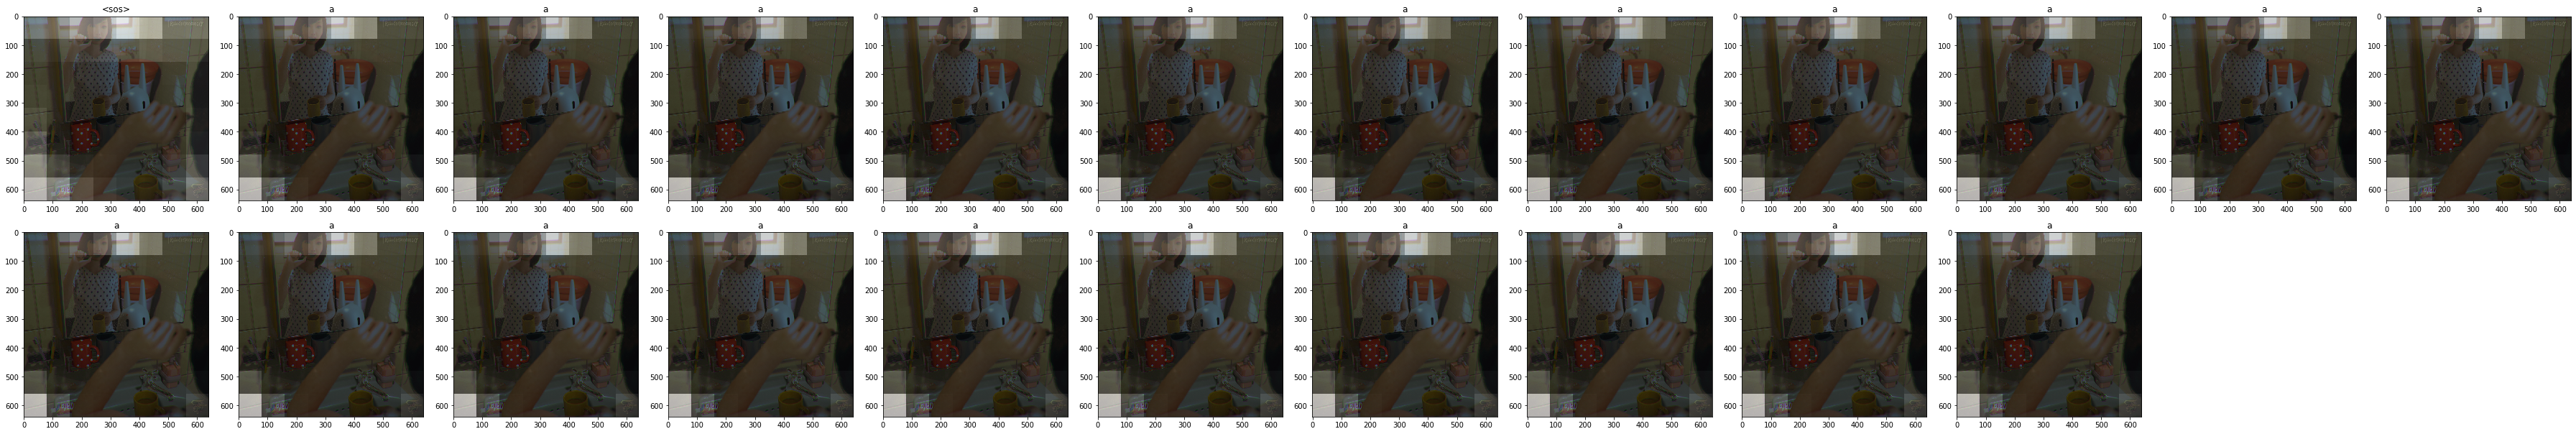

In [22]:
caption_by_index(np.random.randint(0, 200), tokenizer)

## Notes to improve the model:

- Train on multiple captions of the same image.
- Add validation set and exit trying earlier.
- Transfer learning of a better embedding layer.